In [1]:
# Jupter (python) notebook that replicates the data for Table 3 and Figure 4 
# of "Estimating Idiosyncratic Price Setting Behavior with Machine Learning"
# Michael Munsell, Brandeis University (October 2018)

#Import required libraries
import os
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score

#Set up in-line charts
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.color_palette("muted")
%matplotlib inline

#Pathway fundamentals
pd.options.display.max_rows = 1000
working_dir = os.getcwd()
data_path = os.path.join(working_dir,"..","data/expanded")

In [3]:
#Get list of all the file names for category-level data
filenames = []
for dirName, subdirList, fileList in os.walk(data_path):
    for fname in fileList:
        filenames.append(os.path.join(dirName,fname))

filenames = filenames[:-4]

categories = ['Bread and cereals','Meat','Fish and seafood',\
              'Milk, cheese and eggs','Oils and fats','Fruit','Vegetables',\
              'Sugar, jam, etc.']

### Calvo Estimate (not included in paper)

In [8]:
#Calvo results array
calvo_array = np.empty([len(filenames)])

for file in range(0,len(filenames)):
    fulldf = pd.read_csv(filenames[file])
    #Calvo probability
    prob_increase = len(fulldf[fulldf.r_it == 1])/len(fulldf)
    #Set missing inverse duration variables to zero
    fulldf.fillna(value = 0, inplace = True)
    #Set price change variable as binary - 0 is price decrease, 1 is price increase
    ydf =  np.where(fulldf.r_it == -1,0,1)
    rand_vec = np.random.uniform(size=len(fulldf))
    guess_inc = np.where(rand_vec > prob_increase, 0, 1)
    calvo_array[file] = accuracy_score(ydf, guess_inc)

print("Average Accuracy (Calvo): " + str(round(calvo_array.mean(),3)*100) \
      + "%, SD " + str(round(calvo_array.std(),3)))

Average Accuracy (Calvo): 0.510861902211 (SD) 0.0204


### Logistic Regression

In [3]:
#Define baseline linear variables, which includes price duration, overall price level, and dummy variables for time of price change
#All variables are lagged (month before price change)

lin_reg_vars = ['sqrt_duration_lag', 'inv_sqrt_duration_lag', 'chg_p_lag',\
                 'd0_lag', 'd1_lag', 'd2_lag', 'd3_lag', 'd4_lag','d5_lag',\
                'd6_lag','d7_lag','d8_lag','d9_lag','d10_lag','d11_lag','d12_lag','d13_lag',\
                'd14_lag','d15_lag','d16_lag','d17_lag','d18_lag','d19_lag',\
                'd20_lag','d21_lag','d22_lag','d23_lag']

#logistic results array
logr = linear_model.LogisticRegression(penalty='l2', fit_intercept=True, random_state=123)
score_array_logr = np.empty([len(filenames),6])

#Define logistic regression implementation. To be used for each product category
def logistic_class(X, y):
    #Test/train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    size = len(X_train)
    # Train the model 
    logr.fit(X_train, y_train)
    # Make predictions using the test set
    accuracy = logr.score(X_test, y_test)
    # Compute ROC curve, ROC area, precision and recall for each class
    probas_ = logr.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, probas_)
    roc_auc = auc(fpr, tpr)
    precision = precision_score(y_test, logr.predict(X_test))
    recall = recall_score(y_test, logr.predict(X_test))
    return(size, accuracy, tpr, fpr, roc_auc,  precision, recall)

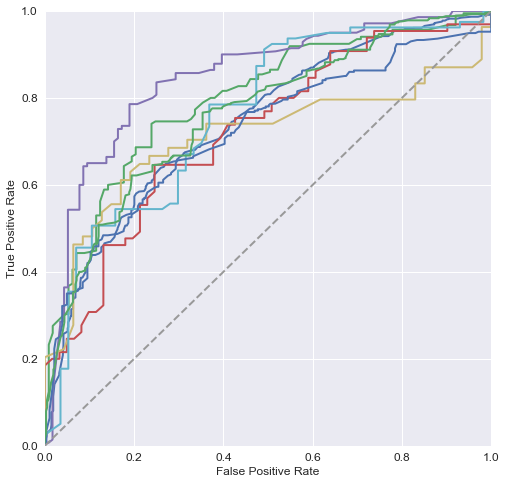

Average Accuracy (Logistic): 69.6%, SD 0.0342
Average Precision (Logistic): 74.3%, SD 0.0498
Average Recall (Logistic): 68.4%, SD 0.0741
Average ROC (Logistic): 75.7%, SD 0.0462


In [4]:
plt.figure(figsize=(8,8))
#Evaluate logistic classifier and record accuracy, percision, and recall for each product cateogry.
for file in range(0,len(filenames)):
    fulldf = pd.read_csv(filenames[file])
    fulldf.fillna(value = 0, inplace = True)
    ydf =  np.where(fulldf.r_it == -1,0,1)
    Xdf = fulldf.loc[:, lin_reg_vars]
    sizedf, accuracydf, tpr_cat, fpr_cat, roc_auc_cat, precision_cat, \
    recall_cat = logistic_class(Xdf, ydf)
    score_array_logr[file, 0] = fulldf.category.unique()[0]
    score_array_logr[file, 1] = sizedf
    score_array_logr[file, 2] = accuracydf
    score_array_logr[file, 3] = roc_auc_cat
    score_array_logr[file, 4] = precision_cat
    score_array_logr[file, 5] = recall_cat
    plt.plot(fpr_cat, tpr_cat, lw=2, label='%s' % (categories[file]))

#Plot ROC curves    
plt.plot([0, 1], [0, 1], '--', \
         color=(0.6, 0.6, 0.6), lw=2, label='Luck')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('False Positive Rate', size=12)
plt.ylabel('True Positive Rate', size=12)
plt.title('Receiver operating characteristic - Multinomial Logistic Regression', size=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ltext = plt.gca().get_legend().get_texts()
plt.setp(ltext[0], fontsize=12)
plt.setp(ltext[1], fontsize=12)
plt.setp(ltext[2], fontsize=12)
plt.setp(ltext[3], fontsize=12)
plt.setp(ltext[4], fontsize=12)
plt.setp(ltext[5], fontsize=12)
plt.setp(ltext[6], fontsize=12)
plt.setp(ltext[7], fontsize=12)
plt.setp(ltext[8], fontsize=12)
plt.show()

#Print aggregate results
logr_results = pd.DataFrame(score_array_logr, columns=['category', 'size', 'accuracy', 'roc', 'precision', 'recall'], dtype=object)
print("Average Accuracy (Logistic): " + str(round(logr_results.accuracy.mean(),3)*100) + "%, SD " + str(round(logr_results.accuracy.std(),4)))
print("Average Precision (Logistic): " + str(round(logr_results.precision.mean(),3)*100)+ "%, SD " + str(round(logr_results.precision.std(),4)))
print("Average Recall (Logistic): " + str(round(logr_results.recall.mean(),3)*100)+ "%, SD " + str(round(logr_results.recall.std(),4)))
print("Average ROC (Logistic): " + str(round(logr_results.roc.mean(),3)*100)+ "%, SD " + str(round(logr_results.roc.std(),4)))

### Ridge Classifier

In [5]:
#Ridge classifier and cross validation set up
alpha_ridge = (1e-2, 1e-1, 10, 20) #Range of possible regularization values
ridge_cv = linear_model.RidgeClassifierCV(alphas = alpha_ridge, cv = 3)
ridge_clf = linear_model.RidgeClassifier(random_state=123)
score_array_ridge_clf = np.empty([len(filenames),6])

def ridge_class(X, y, alpha):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    size = len(X_train)
    # Train the model 
    ridge_clf.fit(X_train, y_train)
    # Make predictions using the test set
    accuracy = ridge_clf.score(X_test, y_test)
    probas_ = ridge_clf.decision_function(X_test)
    # Compute ROC curve, ROC area, precision and recall for each class
    fpr, tpr, _ = roc_curve(y_test, probas_)
    roc_auc = auc(fpr, tpr)
    precision = precision_score(y_test, ridge_clf.predict(X_test))
    recall = recall_score(y_test, ridge_clf.predict(X_test))
    return(size, accuracy, tpr, fpr, roc_auc, precision, recall, ridge_clf.coef_)


Category = Bread and cereals
                         coef
og_lp_na_lag_48596   0.954956
og_lp_na_lag_42646   0.943313
og_lp_na_lag_7084    0.908722
tau_lp_na_lag_12215  0.906143
tau_lp_na_lag_6678   0.906143
og_lp_na_lag_2989    0.893443
og_lp_na_lag_13244   0.890839
og_lp_na_lag_4966    0.882057
og_lp_na_lag_6444    0.882057
og_lp_na_lag_27767   0.875808
og_lp_na_lag_5258    0.862016
og_lp_na_lag_2302    0.862016
og_lp_na_lag_49830   0.845216
og_lp_na_lag_16070   0.842239
og_lp_na_lag_16216   0.842239
og_lp_na_lag_9998    0.842239
og_lp_na_lag_22176   0.839860
og_lp_na_lag_40131   0.839860
tau_lp_na_lag_4928   0.835259
tau_lp_na_lag_6194   0.824360

Category = Meat
                        coef
og_lp_na_lag_49382  1.041331
og_lp_na_lag_35202  0.905966
og_lp_na_lag_46126  0.901166
og_lp_na_lag_10946  0.858353
og_lp_na_lag_5198   0.824255
og_lp_na_lag_38108  0.820640
og_lp_na_lag_1503   0.801961
og_lp_na_lag_46081  0.775923
og_lp_na_lag_21767  0.774547
og_lp_na_lag_6526   0.774547
og_l

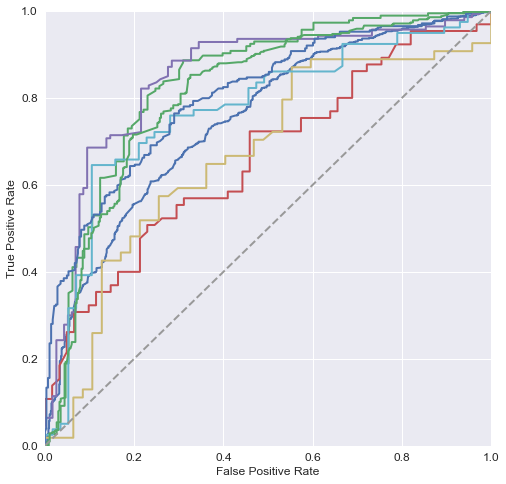

Average Accuracy (Ridge): 70.4%, SD 0.0689
Average Precision (Ridge): 72.2%, SD 0.0673
Average Recall (Ridge): 74.3%, SD 0.1084
Average ROC (Ridge): 76.8%, SD 0.0718


In [6]:
#Evaluate ridge classifier (determine optimal alpha through CV) 
#and record accuracy, percision, and recall for each product cateogry. 
plt.figure(figsize=(8,8))
for file in range(0,len(filenames)):
    fulldf = pd.read_csv(filenames[file])
    fulldf.fillna(value = 0, inplace = True)
    ydf =  np.where(fulldf.r_it == -1,0,1)        
    #Add full competitor's prices/how much the prices have changed since the item's last price change
    ml_reg_vars_add = [col for col in fulldf if col.startswith('tau_')] + [col for col in fulldf if col.startswith('og_')]
    #Divide competitor price variables by each unique item's duration
    Xdf1 = fulldf.loc[:,ml_reg_vars_add].mul(np.array(fulldf.inv_sqrt_duration_lag), axis=0)
    Xdf2 = fulldf.loc[:, lin_reg_vars]
    Xdf = pd.concat([Xdf2,Xdf1], axis=1)
    ml_reg_vars = Xdf.columns.tolist()
    #Determine optimal alpha through 3 fold cross-validation
    alpha_optimal = ridge_cv.fit(Xdf, ydf).alpha_
    sizedf, accuracydf, tpr_cat, fpr_cat, roc_auc_cat, precision_cat, recall_cat, coefdf = ridge_class(Xdf, ydf, alpha_optimal)
    score_array_ridge_clf[file, 0] = fulldf.category.unique()[0]
    score_array_ridge_clf[file, 1] = sizedf
    score_array_ridge_clf[file, 2] = accuracydf
    score_array_ridge_clf[file, 3] = roc_auc_cat
    score_array_ridge_clf[file, 4] = precision_cat
    score_array_ridge_clf[file, 5] = recall_cat
    coef_df = np.transpose(pd.DataFrame((coefdf),  columns = ml_reg_vars, index=['coef']))
    coef_df['coef'] = coef_df['coef'].astype(float)
    coef_df.sort_values(by='coef', ascending = False, inplace=True)
    #Print top 20 variables for each product category
    print("")
    print("Category = " + str(categories[file]))
    print(coef_df[coef_df.coef.astype(float) != 0][:20])
    plt.plot(fpr_cat, tpr_cat, lw=2, label='%s' % (categories[file]))

#Plot ROC curves (carry over formatting from logistic figure)
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), lw=2, label='Luck')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('False Positive Rate', size=12)
plt.ylabel('True Positive Rate', size=12)
plt.title('Receiver operating characteristic - Ridge Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#Print aggregate results
ridge_results = pd.DataFrame(score_array_ridge_clf, columns=['category', 'size', 'accuracy', 'roc', 'precision', 'recall'], dtype=object)
print("Average Accuracy (Ridge): " + str(round(ridge_results.accuracy.mean(),3)*100) + "%, SD " + str(round(ridge_results.accuracy.std(),4)))
print("Average Precision (Ridge): " + str(round(ridge_results.precision.mean(),3)*100)+ "%, SD " + str(round(ridge_results.precision.std(),4)))
print("Average Recall (Ridge): " + str(round(ridge_results.recall.mean(),3)*100)+ "%, SD " + str(round(ridge_results.recall.std(),4)))
print("Average ROC (Ridge): " + str(round(ridge_results.roc.mean(),3)*100)+ "%, SD " + str(round(ridge_results.roc.std(),4)))

### Random Forest Classifier

In [7]:
#Create grid for hyperparamter tuning
from sklearn.model_selection import RandomizedSearchCV

#Number of estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 4)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 4)]
max_depth.append(None)

#Store parameter values
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
rf_param_values = np.empty([len(filenames),2])

#Tune tree depth and number of estimators for each product cateogry
rando_clf = RandomForestClassifier(max_features='sqrt', random_state=123)
rf_randomized = RandomizedSearchCV(estimator = rando_clf, param_distributions = random_grid, cv = 3, random_state=12, n_jobs = -1)


Category = Bread and cereals
          coef                var
23    0.022251            d20_lag
24    0.012195            d21_lag
15    0.010461            d12_lag
25    0.010148            d22_lag
22    0.010101            d19_lag
21    0.010097            d18_lag
20    0.008512            d17_lag
14    0.008205            d11_lag
17    0.007874            d14_lag
16    0.006988            d13_lag
18    0.006861            d15_lag
11    0.005624             d8_lag
12    0.005541             d9_lag
13    0.005012            d10_lag
19    0.004803            d16_lag
9     0.004277             d6_lag
3965  0.003779  og_lp_na_lag_4584
10    0.003726             d7_lag
8     0.003425             d5_lag
6     0.003421             d3_lag

Category = Meat
          coef                 var
23    0.026236             d20_lag
24    0.021868             d21_lag
18    0.017175             d15_lag
12    0.016639              d9_lag
9     0.016360              d6_lag
19    0.013195             d1

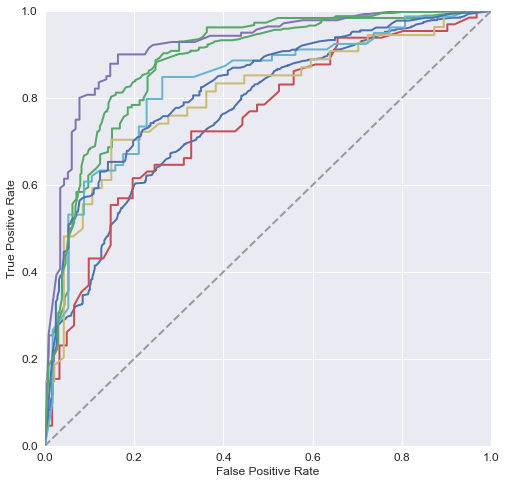

Average Accuracy (Random Forest): 76.4%, SD 0.0598
Average Precision (Random Forest): 78.5%, SD 0.0658
Average Recall (Random Forest): 78.5%, SD 0.0872
Average ROC (Random Forest): 83.2%, SD 0.061


In [8]:
#Random Forest Classifier
score_array_rando_clf = np.empty([len(filenames),6])
plt.figure(figsize=(8,8))

def rando_class(X, y, depth, estimators):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    size = len(X_train)
    # Train the model 
    rando_clf = RandomForestClassifier(max_features='sqrt', random_state=123, max_depth = depth, n_estimators = estimators)
    rando_clf.fit(X_train, y_train)
    # Make predictions using the test set
    accuracy = rando_clf.score(X_test, y_test)
    probas_ = rando_clf.predict_proba(X_test)
    # Compute ROC curve, ROC area, precision and recall for each class
    # Use positive class (i.e., price increase) for evaluating accuracy
    fpr, tpr, _ = roc_curve(y_test, probas_[:,1])
    roc_auc = auc(fpr, tpr)
    precision = precision_score(y_test, rando_clf.predict(X_test))
    recall = recall_score(y_test, rando_clf.predict(X_test))
    return(size, accuracy, tpr, fpr, roc_auc,  precision, recall, rando_clf.feature_importances_)

for file in range(0,len(filenames)):
    fulldf = pd.read_csv(filenames[file])
    fulldf.fillna(value = 0, inplace = True)
    #Zero is price decrease, 1 is price increase
    ydf =  np.where(fulldf.r_it == -1,0,1)        
    ml_reg_vars_add = [col for col in fulldf if col.startswith('tau_')] + [col for col in fulldf if col.startswith('og_')]
    Xdf1 = fulldf.loc[:,ml_reg_vars_add].mul(np.array(fulldf.inv_sqrt_duration_lag), axis=0)
    Xdf2 = fulldf.loc[:, lin_reg_vars]
    Xdf = pd.concat([Xdf2, Xdf1], axis=1)
    ml_reg_vars = Xdf.columns.tolist()
    #Determine optimal tree depth and number of estimators using 3-fold cross validation
    rf_randomized.fit(Xdf, ydf)
    sizedf, accuracydf, tpr_cat, fpr_cat, roc_auc_cat, precision_cat, recall_cat, importances = rando_class(Xdf, ydf, rf_randomized.best_estimator_.max_depth, rf_randomized.best_estimator_.n_estimators)
    score_array_rando_clf[file, 0] = fulldf.category.unique()[0]
    score_array_rando_clf[file, 1] = sizedf
    score_array_rando_clf[file, 2] = accuracydf
    score_array_rando_clf[file, 3] = roc_auc_cat
    score_array_rando_clf[file, 4] = precision_cat
    score_array_rando_clf[file, 5] = recall_cat
    coef_df = pd.DataFrame(np.transpose([importances,ml_reg_vars]), columns = ['coef', 'var']).sort_values(by='coef', ascending = False)
    coef_df['coef'] = coef_df['coef'].astype(float)
    coef_df.sort_values(by='coef', ascending = False, inplace=True)
    #Print top 20 variables for each product category
    print("")
    print("Category = " + str(categories[file]))
    print(coef_df[coef_df.coef.astype(float) != 0][:20])
    plt.plot(fpr_cat, tpr_cat, lw=2, label='%s' % (categories[file]))

#Plot ROC curve
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), lw=2, label='Luck')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('False Positive Rate', size=12)
plt.ylabel('True Positive Rate', size=12)
plt.title('Receiver operating characteristic - Random Forest Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#Print aggregate results
randof_results = pd.DataFrame(score_array_rando_clf, columns=['category', 'size', 'accuracy', 'roc', 'precision', 'recall'], dtype=object)
print("Average Accuracy (Random Forest): " + str(round(randof_results.accuracy.mean(),3)*100) + "%, SD " + str(round(randof_results.accuracy.std(),4)))
print("Average Precision (Random Forest): " + str(round(randof_results.precision.mean(),3)*100)+ "%, SD " + str(round(randof_results.precision.std(),4)))
print("Average Recall (Random Forest): " + str(round(randof_results.recall.mean(),3)*100) + "%, SD " + str(round(randof_results.recall.std(),4)))
print("Average ROC (Random Forest): " + str(round(randof_results.roc.mean(),3)*100) + "%, SD " + str(round(randof_results.roc.std(),4)))

### K-nearest Neighbors

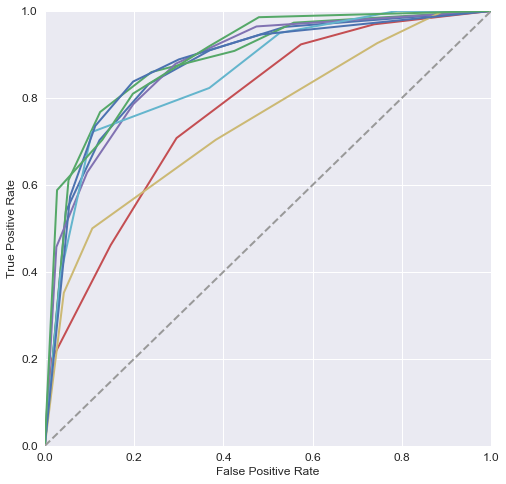

Average Accuracy: 77.0%, SD 0.059
Average Precision: 78.7%, SD 0.0621
Average Recall: 79.5%, SD 0.059
Average ROC: 84.8%, SD 0.0567


In [9]:
#Neighbors to evaluate
neighbors = [int(x) for x in np.linspace(5, 50, num = 10)]
cv = 3
score_array_neigh = np.empty([len(filenames),6])

def neighbor_class(X, y, k_min):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    size = len(X_train)
    # Train the model 
    neigh = KNeighborsClassifier(n_neighbors=k_min)
    neigh.fit(X_train, y_train)
    # Make predictions using the testing set
    accuracy = neigh.score(X_test, y_test)
    probas_ = neigh.predict_proba(X_test)
    # Compute ROC curve, ROC area, precision and recall for each class
    fpr, tpr, _ = roc_curve(y_test, probas_[:,1])
    roc_auc = auc(fpr, tpr)
    precision = precision_score(y_test, neigh.predict(X_test))
    recall = recall_score(y_test, neigh.predict(X_test))
    return(size, accuracy, tpr, fpr, roc_auc,  precision, recall)

plt.figure(figsize=(8,8))
for file in range(0,len(filenames)):
    fulldf = pd.read_csv(filenames[file])
    fulldf.fillna(value = 0, inplace = True)
    #Zero is price decrease, 1 is price increase
    ydf =  np.where(fulldf.r_it == -1,0,1)
    cluster_vars = ['dlprcs_a_lst', 'sqrt_duration_lag', 'lp_na_lag']
    Xdf = fulldf.loc[:, cluster_vars]
    #Find number of neighbors that minimizes the error
    cv_scores_knn = np.empty([len(neighbors),2])
    i = -1
    for k in neighbors:
        i += 1
        neigh = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(neigh, Xdf, ydf, cv=3, scoring='accuracy')
        cv_scores_knn[i, 0] = k
        cv_scores_knn[i, 1] = scores.mean()
    sizedf, accuracydf, tpr_cat, fpr_cat, roc_auc_cat, precision_cat, recall_cat = neighbor_class(Xdf, ydf, cv_scores_knn.min(0)[0].astype(int))
    score_array_neigh[file, 0] = fulldf.category.unique()[0]
    score_array_neigh[file, 1] = sizedf
    score_array_neigh[file, 2] = accuracydf
    score_array_neigh[file, 3] = roc_auc_cat
    score_array_neigh[file, 4] = precision_cat
    score_array_neigh[file, 5] = recall_cat
    #Graph ROC curve
    plt.plot(fpr_cat, tpr_cat, lw=2, label='%s' % (categories[file]))

#Plot ROC curve
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), lw=2, label='Luck')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('False Positive Rate', size=12)
plt.ylabel('True Positive Rate', size=12)
plt.title('Receiver operating characteristic - KNN')
plt.show()

#Print Aggregate Results
kmeans_results = pd.DataFrame(score_array_neigh, columns=['category', 'size', 'accuracy', 'roc', 'precision', 'recall'], dtype=object)
print("Average Accuracy: " + str(round(kmeans_results.accuracy.mean(),3)*100) + "%, SD " + str(round(kmeans_results.accuracy.std(),4)))
print("Average Precision: " + str(round(kmeans_results.precision.mean(),3)*100)+ "%, SD " + str(round(kmeans_results.precision.std(),4)))
print("Average Recall: " + str(round(kmeans_results.recall.mean(),3)*100) + "%, SD " + str(round(kmeans_results.recall.std(),4)))
print("Average ROC: " + str(round(kmeans_results.roc.mean(),3)*100) + "%, SD " + str(round(kmeans_results.roc.std(),4)))